In [534]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor

In [456]:
# Generate dataset to test delays in publication ('publication lags')
def publ_delay(metadata, data, last_date, lag):
    # keep data until the last date
    data_publ_delay = data.loc[data.date <= last_date, :].reset_index(drop=True)
    #  simulate publcation lag for each variable
    for col in data_publ_delay.columns[1:]:
        # extract publication lag from metadata
        pub_lag = metadata.loc[metadata.series == col, "months_lag"].values[0] 
        # simulate publication lag: replace observations within the lag with missing values
        data_publ_delay.loc[(len(data_publ_delay) - pub_lag + lag - 1) :, col] = np.nan

    return data_publ_delay

# Create lagged variables 
def add_lags(data,target_variable, number_lags):
    data_with_lags = data.loc[~pd.isna(data[target_variable]), :]
    index0 = data_with_lags.index   
    for i in range(1, number_lags + 1):
            lag_indices = index0 - i
            lag_indices = lag_indices[lag_indices >= 0]
            tmp = data.loc[lag_indices, :]
            tmp.date = tmp.date + pd.DateOffset(months=i)
            tmp = tmp.drop([target_variable], axis=1)
            tmp.columns = [j + "_" + str(i) if j != "date" else j for j in tmp.columns]
            data_with_lags = data_with_lags.merge(tmp, how="left", on="date")
            
    return data_with_lags

# Prepare data

In [395]:
# Load data
data = pd.read_csv('data/data_forecast.csv')
metadata = pd.read_csv('data/metadata.csv')

In [396]:
data['date'] = pd.to_datetime(data['date'])

In [397]:
data.head()

,date,payems,gdpc,cpiaucsl,unrate,houst,indpro,dspic96,cpilfesl,pcepilfe,pcepi,permit,ulcnfb,a261rx1q020sbea,exports
0,1947-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1947-02-01,0.000505,NaN,0.006518,NaN,NaN,0.005902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1947-03-01,0.001148,NaN,0.017576,NaN,NaN,0.005874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.059965
3,1947-04-01,-0.002477,NaN,0.000000,NaN,NaN,-0.007784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1947-05-01,0.003195,NaN,-0.002273,NaN,NaN,0.003919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [398]:
# Target variable
target_variable = 'exports' 

In [399]:
# Train and test split

# Dates
train_start_date = "1947-01-01"
train_end_date = "2005-12-01"
test_start_date = "2006-03-01"
test_end_date = "2011-12-01"

# Split
train = data.loc[(data['date']>= train_start_date) & (data['date'] <= train_end_date), :].reset_index(drop = True)
test = data.loc[(data['date'] >= train_start_date) & (data['date'] <= test_end_date), :].reset_index(drop = True)

In [400]:
# Define publication lags
lags = list(range(-2,3))

In [401]:
# Impute by forward filling
train_processed = train.fillna(method = 'ffill')

In [402]:
# Impute remaining missing observations by backward filling
train_processed = train_processed.fillna(method = 'bfill')

In [403]:
train_processed = add_lags(train_processed, target_variable,4)

In [404]:
# Keep only quarterly observations
train_processed = train_processed.loc[train_processed['date'].dt.month.isin([3,6,9,12]),:]

In [405]:
# Drop rows with missing lag values 
train_processed = train_processed.dropna(how = 'any', axis = 0).reset_index(drop = True)

# Train models

In [406]:
# train 10 models to average outputs because of stochasticity
models = []
for i in range(10):
    model = RandomForestRegressor(n_estimators = 100, criterion = "absolute_error", max_depth = None, min_samples_split = 2, min_samples_leaf = 1)

    
    x = train_processed.drop(["date", target_variable], axis=1)
    y = train_processed[target_variable]
    
    model.fit(x, y)
    models.append(model)

# Evaluate performance

In [525]:
# Test dates
test_dates = (pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist())

In [526]:
# Test values
test_values = list(test.loc[test.date.isin(test_dates), target_variable].values)

In [527]:
pred_dict = {k: [] for k in lags}
for lag in lags:
    for date in test_dates:
        # the data available for this date at this artificial vintage
        tmp_data = publ_delay(metadata, test, date, lag)

        # Pre-process data
        tmp_data = tmp_data.fillna(method = 'ffill')
        tmp_data = tmp_data.fillna(method = 'bfill')
        tmp_data = flatten_data(tmp_data, target_variable, 4) 
        x = tmp_data.loc[tmp_data['date'] == date, :].drop(['date', target_variable], axis=1)
        
        # average results of 10 models' predictions
        preds = []
        for i in range(10):
            prediction = models[i].predict(x)[0]
            preds.append(prediction)
        
        pred_dict[lag].append(np.nanmean(preds))

# Visualise

In [479]:
# table of RMSE by vintage
performance = pd.DataFrame(columns=["Vintage", "RMSE"])
for lag in lags:
    tmp = pd.DataFrame({
        "Vintage":lag,
        "RMSE":np.sqrt(np.mean((np.array(test_values) - np.array(pred_dict[lag])) ** 2))
    }, index=[0])
    performance = pd.concat([performance, tmp], axis = 0).reset_index(drop=True)
performance.round(4)

,Vintage,RMSE
0,-2,0.0463
1,-1,0.0437
2,0,0.0448
3,1,0.0451
4,2,0.0437


''

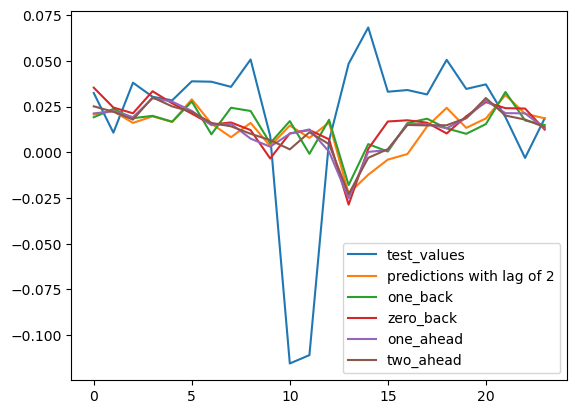

In [528]:
# plot of predictions vs test_values
pd.DataFrame({
    "test_values":test_values, 
    "predictions with lag of 2":pred_dict[-2], 
    "one_back":pred_dict[-1], 
    "zero_back":pred_dict[0],
    "one_ahead":pred_dict[1],
    "two_ahead":pred_dict[2]}
).plot()
;

In [536]:
# plot of predictions vs test_values
data_plot = pd.DataFrame({
    "true values":test_values, 
    "predictions with lag of 2":pred_dict[-2], 
    "predictions with lag of 1":pred_dict[-1], 
    "predictions with no lag":pred_dict[0],
    "predictions with 1 year ahead":pred_dict[1],
    "predictions with 2 years ahead":pred_dict[2]}, 
    index = test_dates)

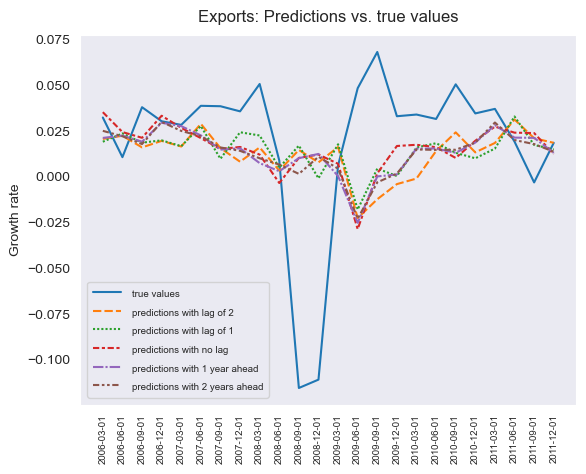

In [561]:
sns.set_style("dark")
ax = sns.lineplot(data=data_plot)


plt.setp(ax.get_legend().get_texts(), fontsize='7') # for legend text

plt.xticks(rotation = 90, fontsize=7)
plt.ylabel("Growth rate", fontsize=10)

plt.title("Exports: Predictions vs. true values", y=1.013);

# Use best model to predict Exports

In [502]:
# Expand test set by adding dates up to the desired date 
ext_test_data = test.copy()
prediction_date = pd.to_datetime("2013-01-01")

while prediction_date > np.max(ext_test_data.date):
    ext_test_data.loc[len(ext_test_data), "date"] = np.max(ext_test_data.date) + pd.DateOffset(months=1)

In [503]:
ext_test_data.tail()

,date,payems,gdpc,cpiaucsl,unrate,houst,indpro,dspic96,cpilfesl,pcepilfe,pcepi,permit,ulcnfb,a261rx1q020sbea,exports
788,2012-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
789,2012-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
790,2012-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
791,2012-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
792,2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [504]:
# Pre-process data
ext_test_data_processed = ext_test_data.fillna(method = 'ffill')
ext_test_data_processed = ext_test_data_processed.fillna(method = 'bfill')
ext_test_data_processed = flatten_data(ext_test_data_processed, target_variable, 4) 

In [505]:
ext_test_data_processed[['date','exports']].tail()

,date,exports
788,2012-09-01,0.018538
789,2012-10-01,0.018538
790,2012-11-01,0.018538
791,2012-12-01,0.018538
792,2013-01-01,0.018538


In [506]:
x = ext_test_data_processed.loc[ext_test_data_processed['date'] == prediction_date, :].drop(['date', target_variable], axis=1)

In [511]:
preds = []
for i in range(10):
    prediction = models[i].predict(x)[0]
    preds.append(prediction)
        
np.nanmean(preds)

0.007737240980557221